## Helical Elongation

$$ R = R_0 + \delta\cos(N\varphi) + \rho(\cos\theta+(\kappa-1)\sin\eta\sin(N\varphi)) $$
$$ \phi = -\varphi $$
$$ Z = \delta\sin(N\varphi) + \rho(\sin\theta-(\kappa-1)\sin\eta\cos(N\varphi))$$

$$ \eta=N\varphi-\theta $$

In [1]:
import dcs.localEquilibrium
import dcs.geometry
import dcs.toroidalField

import numpy as np
try:
    import matplotlib
    matplotlib.rcParams['text.usetex'] = True
except:
    pass
import matplotlib.pyplot as plt

In [2]:
r0 = 2 
rho = 0.02
delta = 0.02
nfp = 100
kappa = 1.5

funR = lambda thetaArr, phiArr: r0 + delta*np.cos(nfp*phiArr) + rho * (
    np.cos(thetaArr) + (kappa-1)*np.sin(nfp*phiArr-thetaArr)*np.sin(nfp*phiArr)
) 
funZ = lambda thetaArr, phiArr: delta*np.sin(nfp*phiArr) + rho * (
    np.sin(thetaArr) - (kappa-1)*np.sin(nfp*phiArr-thetaArr)*np.cos(nfp*phiArr)
)

In [3]:
sampleNumsTheta, sampleNumsPhi = 5, 5
deltaTheta = 2*np.pi / (2*sampleNumsTheta+1)
deltaVarPhi = 2*np.pi / nfp / (2*sampleNumsPhi+1)
sampleTheta, sampleVarPhi = np.arange(2*sampleNumsTheta+1)*deltaTheta, np.arange(2*sampleNumsPhi+1)*deltaVarPhi
gridSampleVarPhi, gridSampleTheta = np.meshgrid(sampleVarPhi, sampleTheta)
sampleR = funR(gridSampleTheta, - gridSampleVarPhi)
sampleZ = funZ(gridSampleTheta, - gridSampleVarPhi)

fieldR = dcs.toroidalField.fftToroidalField(sampleR, nfp=nfp)
fieldZ = dcs.toroidalField.fftToroidalField(sampleZ, nfp=nfp)

surfHelicalAxis = dcs.geometry.Surface(fieldR, fieldZ)

$$ N^2\delta \gg R_0, \ \ \ \frac{N\delta}{R_0}\sim\frac{N\rho}{R_0}\sim 1, \ \ \ \kappa-1\sim 1$$

$$ \sqrt{g} \approx \sqrt{g}_0 (1 + \epsilon_h\cos\eta + \epsilon_{2h}\cos(2\eta)) $$

$$ B^2 \approx \frac{R_0^2+N^2\delta^2+N^2\rho^2(\kappa-1)^2-2N^2\delta\rho(\kappa-1)\cos\eta}{\sqrt{g}^2} $$

$$ \epsilon_h = \frac{N^2\delta\rho(2-\kappa)}{R_0^2+N^2\delta^2+N^2\rho^2(\kappa-1)^2/2} $$

In [4]:
epsilon_h = (
    (nfp*nfp*delta*rho*(2-kappa))
    / (r0*r0 + nfp*nfp*delta*delta + nfp*nfp*rho*rho*(kappa-1)*(kappa-1)/2)
)
epsilon_2h = (
    - (nfp*nfp*rho*rho*(kappa*kappa-1)/2)
    / (r0*r0 + nfp*nfp*delta*delta + nfp*nfp*rho*rho*(kappa-1)*(kappa-1)/2)
)

def funG(thetaArr: np.ndarray, phiArr: np.ndarray) -> np.ndarray: 
    etaArr = nfp*phiArr - thetaArr
    return 1 + epsilon_h*np.cos(etaArr) + epsilon_2h*np.cos(2*etaArr)


def funB2(thetaArr: np.ndarray, phiArr: np.ndarray) -> np.ndarray:
    etaArr = nfp*phiArr - thetaArr
    return (
        (r0*r0 + nfp*nfp*delta*delta + nfp*nfp*rho*rho*(kappa-1)*(kappa-1) - 2*nfp*nfp*delta*rho*(kappa-1)*np.cos(etaArr))
        / np.power(funG(thetaArr, phiArr), 2)
    )

def getAveG():
    from scipy.integrate import dblquad 
    def _tem(thetaArr: np.ndarray, varphiArr: np.ndarray) -> np.ndarray:
        return 1/funG(thetaArr, varphiArr)
    return dblquad(_tem, 0, 2*np.pi, 0, 2*np.pi)[0] / np.pi / np.pi / 4

aveG = getAveG()

In [5]:
iota = 1

surfaceProblem = dcs.localEquilibrium.StraightSurfaceField(surfHelicalAxis, iota=iota)

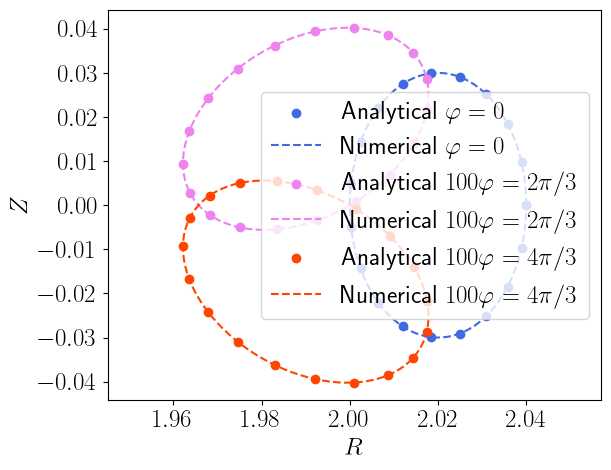

In [6]:
fig, ax = plt.subplots()
ax.scatter(
    funR(np.linspace(0,2*np.pi,20), np.ones(20)*0), funZ(np.linspace(0,2*np.pi,20), np.ones(20)*0), 
    c = "royalblue",
    label = "Analytical " + r"$\varphi=0$"
)
ax.plot(
    surfaceProblem.surf.r.getValue(np.linspace(0,2*np.pi,100),np.ones(100)*0).flatten(), 
    surfaceProblem.surf.z.getValue(np.linspace(0,2*np.pi,100),np.ones(100)*0).flatten(), 
    c = "royalblue", 
    ls = "--", 
    label = "Numerical " + r"$\varphi=0$"
)
ax.scatter(
    funR(np.linspace(0,2*np.pi,20), np.ones(20)*2*np.pi/3), funZ(np.linspace(0,2*np.pi,20), np.ones(20)*2*np.pi/3), 
    c = "violet",
    label = "Analytical $" + str(nfp) + r"\varphi=2\pi/3$"
)
ax.plot(
    surfaceProblem.surf.r.getValue(np.linspace(0,2*np.pi,100),np.ones(100)*2*np.pi/3).flatten(), 
    surfaceProblem.surf.z.getValue(np.linspace(0,2*np.pi,100),np.ones(100)*2*np.pi/3).flatten(), 
    c = "violet", 
    ls = "--", 
    label = "Numerical $" + str(nfp) + r"\varphi=2\pi/3$"
)
ax.scatter(
    funR(np.linspace(0,2*np.pi,20), np.ones(20)*4*np.pi/3), funZ(np.linspace(0,2*np.pi,20), np.ones(20)*4*np.pi/3), 
    c = "orangered",
    label = "Analytical $" + str(nfp) + r"\varphi=4\pi/3$"
)
ax.plot(
    surfaceProblem.surf.r.getValue(np.linspace(0,2*np.pi,100),np.ones(100)*4*np.pi/3).flatten(), 
    surfaceProblem.surf.z.getValue(np.linspace(0,2*np.pi,100),np.ones(100)*4*np.pi/3).flatten(), 
    c = "orangered", 
    ls = "--", 
    label = "Numerical $" + str(nfp) + r"\varphi=4\pi/3$"
)
ax.legend(fontsize=18)
ax.set_xlabel(r"$R$", fontsize=18)
ax.set_ylabel(r"$Z$", fontsize=18)
_, _ = plt.xticks(fontsize=18), plt.yticks(fontsize=18)
_ = plt.axis("equal")
fig.tight_layout()

In [7]:
surfaceProblem.solveJacobian() 
surfaceProblem.solveJacobianReciprocal()

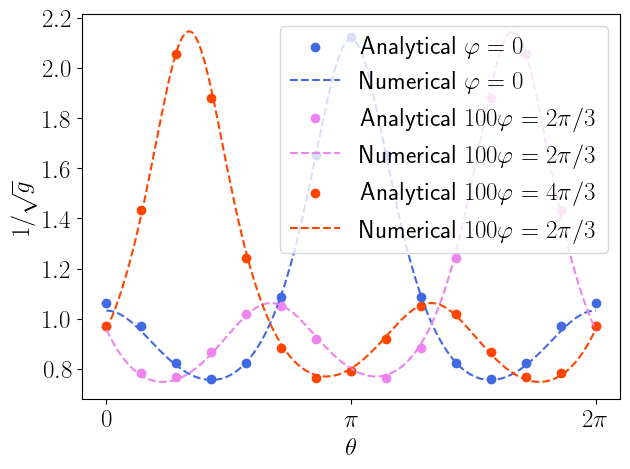

In [8]:
fig, ax = plt.subplots()
ax.scatter(
    np.linspace(0, 2*np.pi, 15), 1/funG(np.linspace(0, 2*np.pi, 15), np.ones(15)*0), 
    c = "royalblue",
    label = "Analytical " + r"$\varphi=0$"
)
ax.plot(
    np.linspace(0, 2*np.pi, 150), 
    surfaceProblem.JacobianReciprocal.getValue(np.linspace(0,2*np.pi,150),np.ones(150)*0).flatten()*aveG,  
    c = "royalblue", 
    ls = "--", 
    label = "Numerical " + r"$\varphi=0$"
)
ax.scatter(
    np.linspace(0, 2*np.pi, 15), 1/funG(np.linspace(0, 2*np.pi, 15), np.ones(15)*2*np.pi/3),
    c = "violet",
    label = "Analytical $" + str(nfp) + r"\varphi=2\pi/3$"
)
ax.plot(
    np.linspace(0, 2*np.pi, 150), 
    surfaceProblem.JacobianReciprocal.getValue(np.linspace(0,2*np.pi,150),np.ones(150)*2*np.pi/3).flatten()*aveG,  
    c = "violet", 
    ls = "--", 
    label = "Numerical $" + str(nfp) + r"\varphi=2\pi/3$"
)
ax.scatter(
    np.linspace(0, 2*np.pi, 15), 1/funG(np.linspace(0, 2*np.pi, 15), np.ones(15)*4*np.pi/3),
    c = "orangered",
    label = "Analytical $" + str(nfp) + r"\varphi=4\pi/3$"
)
ax.plot(
    np.linspace(0, 2*np.pi, 150), 
    surfaceProblem.JacobianReciprocal.getValue(np.linspace(0,2*np.pi,150),np.ones(150)*4*np.pi/3).flatten()*aveG,  
    c = "orangered", 
    ls = "--", 
    label = "Numerical $" + str(nfp) + r"\varphi=2\pi/3$"
)
ax.legend(fontsize=18)
ax.set_xlabel(r"$\theta$", fontsize=18)
ax.set_ylabel(r"$1/\sqrt{g}$", fontsize=18)
ax.set_xticks(np.linspace(0, 2*np.pi, 3))
ax.set_xticklabels(["$0$", r"$\pi$", r"$2\pi$"], fontsize=18)
_ = plt.yticks(fontsize=18)
fig.tight_layout()

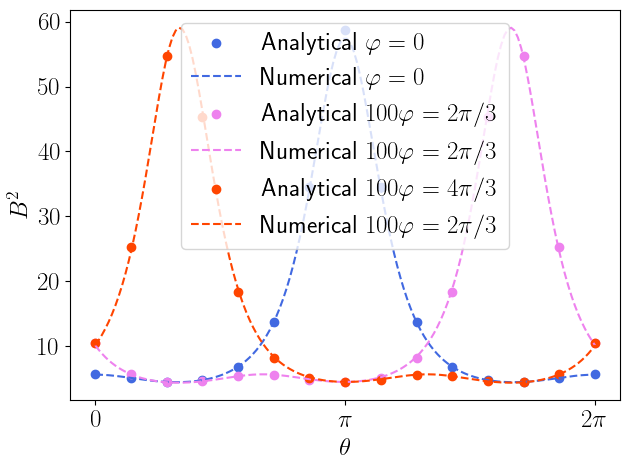

In [9]:
fig, ax = plt.subplots()
ax.scatter(
    np.linspace(0, 2*np.pi, 15), funB2(np.linspace(0, 2*np.pi, 15), np.ones(15)*0), 
    c = "royalblue",
    label = "Analytical " + r"$\varphi=0$"
)
ax.plot(
    np.linspace(0, 2*np.pi, 150), 
    np.power(surfaceProblem.getB(np.linspace(0,2*np.pi,150),np.ones(150)*0).flatten(), 2)*aveG*aveG,  
    c = "royalblue", 
    ls = "--", 
    label = "Numerical " + r"$\varphi=0$"
)
ax.scatter(
    np.linspace(0, 2*np.pi, 15), funB2(np.linspace(0, 2*np.pi, 15), np.ones(15)*2*np.pi/3),
    c = "violet",
    label = "Analytical $" + str(nfp) + r"\varphi=2\pi/3$"
)
ax.plot(
    np.linspace(0, 2*np.pi, 150), 
    np.power(surfaceProblem.getB(np.linspace(0,2*np.pi,150),np.ones(150)*2*np.pi/3).flatten(), 2)*aveG*aveG,  
    c = "violet", 
    ls = "--", 
    label = "Numerical $" + str(nfp) + r"\varphi=2\pi/3$"
)
ax.scatter(
    np.linspace(0, 2*np.pi, 15), funB2(np.linspace(0, 2*np.pi, 15), np.ones(15)*4*np.pi/3),
    c = "orangered",
    label = "Analytical $" + str(nfp) + r"\varphi=4\pi/3$"
)
ax.plot(
    np.linspace(0, 2*np.pi, 150), 
    np.power(surfaceProblem.getB(np.linspace(0,2*np.pi,150),np.ones(150)*4*np.pi/3).flatten(), 2)*aveG*aveG,  
    c = "orangered", 
    ls = "--", 
    label = "Numerical $" + str(nfp) + r"\varphi=2\pi/3$"
)
ax.legend(fontsize=18)
ax.set_xlabel(r"$\theta$", fontsize=18)
ax.set_ylabel(r"$B^2$", fontsize=18)
ax.set_xticks(np.linspace(0, 2*np.pi, 3))
ax.set_xticklabels(["$0$", r"$\pi$", r"$2\pi$"], fontsize=18)
_ = plt.yticks(fontsize=18)
fig.tight_layout()